In [1]:
# =======================
# COMMON FUNCTIONS
# =======================
import numpy as np
import tarfile

def loadTGZ(tgz, fPath, dtype, skip_header=False):
    """
    Load a CSV file from the tarfile 'tgz' given its file path 'fPath'.  
    Optionally skip the header row (if skip_header=True). 
    Reshape the data into 256*256 and cast to the specified dtype.
    """
    with tgz.extractfile(fPath) as csvfile:
        data = np.genfromtxt(csvfile, delimiter=",", skip_header=1 if skip_header else 0)
        if data.size != 256*256:
            raise ValueError(f"Data size mismatch in {fPath}: expected {256*256}, got {data.size}")
        return data.reshape(256*256).astype(dtype)

def removeMaskNaN(outSet):
    """Remove entries with NaN in any file and entries with mask != 0."""
    aMask = (outSet["mask"] == 0)
    for k in outSet.keys():
        aMask &= ~np.isnan(outSet[k])
    for k in outSet.keys():
        outSet[k] = outSet[k][aMask]
    return outSet

def normSet(outSet):
    """
    Normalize the variables in a consistent way (using a sensor-specific offset)
    to allow comparisons between sensors.
    """
    offset = np.mean(outSet["tMean0"]).astype(np.float16)
    outSet["tMean0"] = (outSet["tMean0"] - offset) / 75.
    outSet["tMeanF"] = (outSet["tMeanF"] - (offset + 150)) / 75.
    outSet["tWidth0"] = (outSet["tWidth0"] - 10) / 7.5
    outSet["tWidthF"] = (outSet["tWidthF"] - 10) / 7.5
    return outSet

# =======================
# CELL 1: OLD DATA LOADING
# =======================
tgzFileName = "ASideFirstModules.tgz"

# Define module training list for old data
moduleFiles = [
    "equalisation_M98_A1",
    "equalisation_M94_A2",
    "equalisation_M96_A3",
    "equalisation_M59_A4",
    "equalisation_N22_A5",
    "equalisation_M116_A6",
    "equalisation_N030_A7",
    "equalisation_M90_A8",
    "equalisation_N029_A9",
    "equalisation_N013_A10"
]

# Define training set (to be excluded from evaluation)
trainingSet = [
    ("equalisation_N030_A7","VP0-1"), #offset = 2
    ("equalisation_M59_A4","VP0-0"), #offset = 1
    ("equalisation_M98_A1","VP0-1"), #offset = 0
    ("equalisation_N030_A7","VP3-2"), #offset = -1
    ("equalisation_M98_A1","VP2-0") #offset = -2
]

vpList = [f"VP{i}-{j}" for i in range(4) for j in range(3)]
evaluationSet = [(f, vp) for f in moduleFiles for vp in vpList]
evaluationSet = [s for s in evaluationSet if s not in trainingSet]

print(f"Old Data:\n Training set: {trainingSet}\n {len(evaluationSet)} evaluation sets to test.")
print("First:", evaluationSet[0], "Last:", evaluationSet[-1])

def extractFromTGZ(tgzName, dSet):
    """
    Extract the old data files for a given dataset dSet.
    dSet is a tuple: (module_name, vp), e.g. ("equalisation_M98_A1", "VP0-1").
    """
    path = dSet[0] + "/"
    outSet = {}
    with tarfile.open(tgzName, 'r:gz') as tgz:
        outSet["tMean0"] = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Trim0_Noise_Mean.csv", np.float16)
        outSet["tMeanF"] = loadTGZ(tgz, path + f"Module0_{dSet[1]}_TrimF_Noise_Mean.csv", np.float16)
        outSet["tWidth0"] = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Trim0_Noise_Width.csv", np.float16)
        outSet["tWidthF"] = loadTGZ(tgz, path + f"Module0_{dSet[1]}_TrimF_Noise_Width.csv", np.float16)
        outSet["mask"]    = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Matrix_Mask.csv", np.float16)
        outSet["trim"]    = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Matrix_Trim.csv", np.int8)
    return removeMaskNaN(outSet)


Old Data:
 Training set: [('equalisation_N030_A7', 'VP0-1'), ('equalisation_M59_A4', 'VP0-0'), ('equalisation_M98_A1', 'VP0-1'), ('equalisation_N030_A7', 'VP3-2'), ('equalisation_M98_A1', 'VP2-0')]
 115 evaluation sets to test.
First: ('equalisation_M98_A1', 'VP0-0') Last: ('equalisation_N013_A10', 'VP3-2')


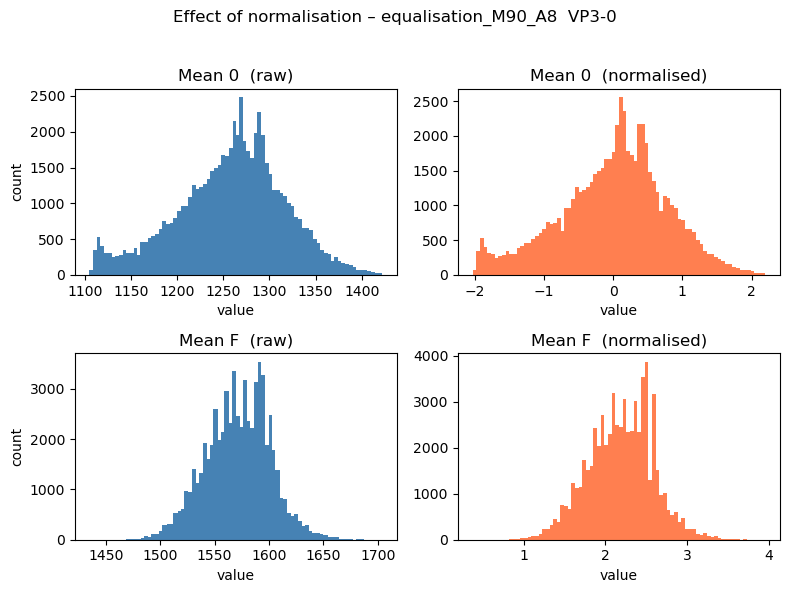

In [6]:
# ----------------------------------------------------------
#  PLOT raw vs. normalised  for  tMean0  and  tMeanF
# ----------------------------------------------------------
import matplotlib.pyplot as plt

def plot_norm_effect(example=("equalisation_M90_A8", "VP3-0")):
    """
    Draw over‑laid histograms of Mean‑0 and Mean‑F before/after normalisation.
    `example` is any (module, tile) tuple from your evaluationSet/trainingSet.
    """
    # 1) --- load one tile ---------------------------------
    raw = extractFromTGZ(tgzFileName, example)   # your helper
    raw_mean0 = raw["tMean0"].copy()             # keep originals
    raw_meanF = raw["tMeanF"].copy()

    # 2) --- apply your normalisation ----------------------
    normed = normSet(raw)                        # in‑place change!
    norm_mean0 = normed["tMean0"]
    norm_meanF = normed["tMeanF"]

    # 3) --- plot (separate panels) ---------------------------------------
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))

    bins_raw   = 80
    bins_norm  = 80

    # row 0 : Mean 0
    ax[0,0].hist(raw_mean0,  bins_raw,  color="steelblue")
    ax[0,0].set_title("Mean 0  (raw)");     ax[0,0].set_xlabel("value"); ax[0,0].set_ylabel("count")

    ax[0,1].hist(norm_mean0, bins_norm, color="coral")
    ax[0,1].set_title("Mean 0  (normalised)"); ax[0,1].set_xlabel("value")

    # row 1 : Mean F
    ax[1,0].hist(raw_meanF,  bins_raw,  color="steelblue")
    ax[1,0].set_title("Mean F  (raw)");     ax[1,0].set_xlabel("value"); ax[1,0].set_ylabel("count")

    ax[1,1].hist(norm_meanF, bins_norm, color="coral")
    ax[1,1].set_title("Mean F  (normalised)"); ax[1,1].set_xlabel("value")

    fig.suptitle(f"Effect of normalisation – {example[0]}  {example[1]}")
    fig.tight_layout(rect=[0,0,1,0.96])
    plt.show()      

# ----------------------------------------------------------
# call it once:
plot_norm_effect()          # or plot_norm_effect(("equalisation_M59_A4","VP1-1"))





In [4]:
# =======================
# CELL 2: NEW OPERATIONAL DATA LOADING
# =======================
tgzFileName_new = "Module25_20230621_trim.tgz"

# For the new data, the module prefix is fixed as "Module25".
evaluationSet_new = [("Module25", vp) for vp in vpList]

print(f"\nNew Operational Data:\n {len(evaluationSet_new)} evaluation sets to test.")
print("First:", evaluationSet_new[0], "Last:", evaluationSet_new[-1])

def extractFromTGZ_new(tgzName, dSet):
    """
    Extract the new operational data files for a given dataset dSet.
    dSet is a tuple: (module_prefix, vp), e.g. ("Module25", "VP0-0").
    For noise files, we skip the header row; for matrix files, we do not.
    """
    module_prefix, vp = dSet
    outSet = {}
    with tarfile.open(tgzName, 'r:gz') as tgz:
        # Noise files (skip header)
        outSet["tMean0"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Trim0_Noise_Mean_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        outSet["tMeanF"] = loadTGZ(tgz, f"{module_prefix}_{vp}_TrimF_Noise_Mean_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        outSet["tWidth0"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Trim0_Noise_Width_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        outSet["tWidthF"] = loadTGZ(tgz, f"{module_prefix}_{vp}_TrimF_Noise_Width_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        # Matrix files (do not skip header)
        outSet["mask"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Matrix_Mask_2023-06-21_14-06-30.csv", np.float16, skip_header=False)
        outSet["trim"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Matrix_Trim_2023-06-21_14-06-30.csv", np.int8, skip_header=False)
    return removeMaskNaN(outSet)


New Operational Data:
 12 evaluation sets to test.
First: ('Module25', 'VP0-0') Last: ('Module25', 'VP3-2')


In [5]:
from matplotlib import pyplot as plt

# Now plot the data to see what we have as a training set

def plotCorr(ax,trim,val,ytitle):
    xBins = np.arange(-0.5,15.5,1)
    yBins = np.linspace(np.min(val),np.max(val),100)
    ax.hist2d(trim,val,bins=[xBins,yBins])
    ax.set_xlabel('Final Trim')
    ax.set_ylabel(ytitle)

def drawSet(dSet, title='Dataset', norm=False):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(14,3))
    fig.suptitle(title)
    # final Trim
    ax1.hist(dSet["trim"],bins=np.arange(-0.5,15.5))
    ax1.set_xlabel('Final Trim')
    # mean0 & F
    if norm :
        bins = np.linspace(-2,2,128)
    else :
        bins = np.linspace(-0.5,2047.5,128)
    ax2.hist(dSet["tMean0"], bins=bins, label = "0 Mean")
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_xlabel('Mean 0')
    ax3.hist(dSet["tMeanF"], bins=bins, label = "F Mean")
    ax3.legend()
    ax3.set_yscale('log')
    ax3.set_xlabel('Mean F')
    # widths
    if norm :
        bins = np.linspace(-2,2,128)
    else :
        bins = np.linspace(-0.5,25.5, 26)
    ax4.hist(dSet["tWidth0"], bins=bins, label = "0 Width")
    ax4.legend()
    ax4.set_yscale('log')
    ax4.set_xlabel('Width 0')
    ax5.hist(dSet["tWidthF"], bins=bins, label = "F Width")
    ax5.legend()
    ax5.set_yscale('log')
    ax5.set_xlabel('Width F')
    plt.tight_layout()
    plt.show()
    # now correlations
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(12,3))
    plotCorr(ax0,dSet["trim"],dSet["tMean0"],'Mean 0')
    plotCorr(ax1,dSet["trim"],dSet["tMeanF"],'Mean F')
    plotCorr(ax2,dSet["trim"],dSet["tWidth0"],'Width 0')
    plotCorr(ax3,dSet["trim"],dSet["tWidthF"],'Width F')
    plt.tight_layout()
    plt.show()

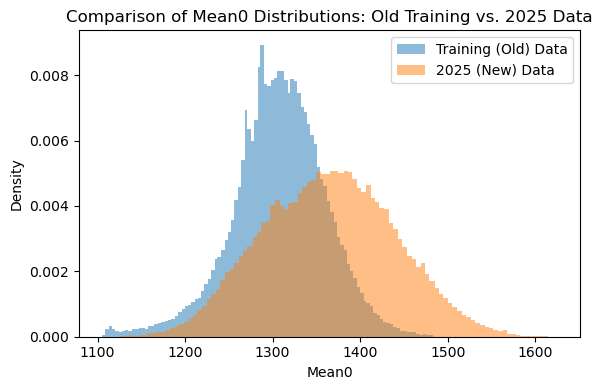

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Gather Mean0 values from the old training sets
old_mean0 = []
for ds in trainingSet:
    # ds is a tuple, e.g. ("equalisation_N030_A7", "VP0-1")
    out = extractFromTGZ(tgzFileName, ds)              # apply your normalization
    old_mean0.extend(out["tMean0"])   # collect tMean0 for this dataset

# 2) Gather Mean0 values from the new 2025 data
new_mean0 = []
for ds in evaluationSet_new:
    # ds is a tuple, e.g. ("Module25", "VP0-0")
    out_new = extractFromTGZ_new(tgzFileName_new, ds)
    new_mean0.extend(out_new["tMean0"])

# Convert to NumPy arrays (if needed)
old_mean0 = np.array(old_mean0)
new_mean0 = np.array(new_mean0)

# 3) Plot the distributions side-by-side or overlaid in the same figure
plt.figure(figsize=(6, 4))
plt.hist(old_mean0, bins=100, alpha=0.5, label="Training (Old) Data", density=True)
plt.hist(new_mean0, bins=100, alpha=0.5, label="2025 (New) Data", density=True)
plt.xlabel("Mean0")
plt.ylabel("Density")
plt.title("Comparison of Mean0 Distributions: Old Training vs. 2025 Data")
plt.legend()
plt.tight_layout()
plt.show()


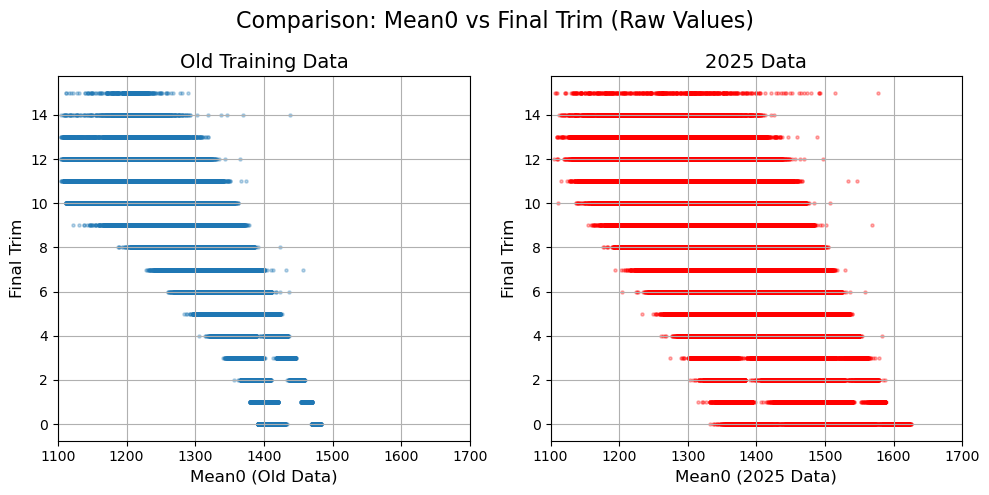

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Gather old training data: Mean0 and final trim
old_mean0 = []
old_trim = []
for ds in trainingSet:
    out = extractFromTGZ(tgzFileName, ds)
    # skip normSet() if you want raw values
    old_mean0.extend(out["tMean0"])
    old_trim.extend(out["trim"])

old_mean0 = np.array(old_mean0)
old_trim = np.array(old_trim)

# 2) Gather new 2025 data: Mean0 and final trim
new_mean0 = []
new_trim = []
for ds in evaluationSet_new:
    out_new = extractFromTGZ_new(tgzFileName_new, ds)
    new_mean0.extend(out_new["tMean0"])
    new_trim.extend(out_new["trim"])

new_mean0 = np.array(new_mean0)
new_trim = np.array(new_trim)


# 3) Plot side-by-side: Mean0 vs. final trim for old data (left), new data (right)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left: old data scatter
axes[0].scatter(old_mean0, old_trim, s=5, alpha=0.3)
axes[0].set_xlabel("Mean0 (Old Data)", fontsize=12)
axes[0].set_ylabel("Final Trim", fontsize=12)
axes[0].set_title("Old Training Data", fontsize=14)
axes[0].grid(True)
axes[0].set_xlim(1100, 1700)

# Right: new data scatter
axes[1].scatter(new_mean0, new_trim, s=5, alpha=0.3, color='red')
axes[1].set_xlabel("Mean0 (2025 Data)", fontsize=12)
axes[1].set_ylabel("Final Trim", fontsize=12)
axes[1].set_title("2025 Data", fontsize=14)
axes[1].grid(True)
axes[1].set_xlim(1100, 1700)

plt.suptitle("Comparison: Mean0 vs Final Trim (Raw Values)", fontsize=16)
plt.tight_layout()
plt.show()


Loaded and normalized training data for: ('equalisation_N030_A7', 'VP0-1')
Loaded and normalized training data for: ('equalisation_M59_A4', 'VP0-0')
Loaded and normalized training data for: ('equalisation_M98_A1', 'VP0-1')
Loaded and normalized training data for: ('equalisation_N030_A7', 'VP3-2')
Loaded and normalized training data for: ('equalisation_M98_A1', 'VP2-0')
Final Combined Training Set Shapes:
tMean0: (326251,)
tMeanF: (326251,)
tWidth0: (326251,)
tWidthF: (326251,)
trim: (326251,)
dataLen = 326251, nVars = 4
5098/5098 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - adjacent_accuracy: 0.0945 - loss: 2.8136 - sparse_categorical_accuracy: 0.0281
Initial loss:  2.7865 with the random starting network
Initial accuracy:  0.0429, expect 1/16 = 0.06 by chance
Epoch 1/10000
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - adjacent_accuracy: 0.3806 - loss: 2.5946 - sparse_categorical_accuracy: 0.1308
Epoch 2/10000
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - adjacent_accuracy: 0.7003 - loss: 2.0127 - spa

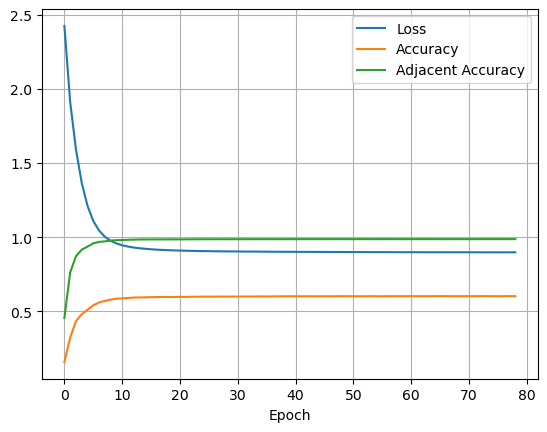

Model trained on {'tMean0': array([-1.693 ,  0.28  ,  1.026 , ...,  0.88  ,  0.28  ,  0.2534],
      dtype=float16), 'tMeanF': array([1.974 , 2.254 , 2.56  , ..., 0.7866, 0.24  , 0.4666], dtype=float16), 'tWidth0': array([ 0.67  , -0.2094, -0.3052, ..., -0.4922, -0.52  , -0.2031],
      dtype=float16), 'tWidthF': array([-0.641 , -0.6357, -0.8   , ..., -0.631 , -0.64  , -0.544 ],
      dtype=float16), 'trim': array([10,  7,  4, ...,  3,  8,  7], dtype=int8)} saved to NN_equalisation_N030_A7_VP0-1.keras
Total training time: 36.95 seconds


In [8]:
from matplotlib import pyplot as plt
# Keras network used as front end to Tensorflow
# See https://keras.io/ for details of the package
# import Keras overall
import keras
# input normalization layer [fixes input variables to useful range]
from keras.layers import BatchNormalization
# a single NN layer of type "Dense" i.e. all inputs connected to all outputs
from keras.layers import Dense
# The input layer, takes x and starts NN processing
from keras.layers import Input
# Keras functional methods for defining a NN model
from keras.models import Model
import time  # Import time module
import keras_tuner as kt
from keras.saving import register_keras_serializable

trainSets = []
for dSet in trainingSet:
    try:
        outSet = extractFromTGZ(tgzFileName, dSet)
        outSet_norm = normSet(outSet)
        trainSets.append(outSet_norm)
        print("Loaded and normalized training data for:", dSet)
    except Exception as e:
        print("Error loading training data for", dSet, ":", e)

# Initialize a dictionary to store combined training data
combined_trainSet = {
    "tMean0": [],
    "tMeanF": [],
    "tWidth0": [],
    "tWidthF": [],
    "trim": []
}

# Merge all normalized datasets into one
for trainSet in trainSets:
    for key in combined_trainSet.keys():
        combined_trainSet[key].extend(trainSet[key])  # Append each dataset

# Convert lists to NumPy arrays
for key in combined_trainSet.keys():
    combined_trainSet[key] = np.array(combined_trainSet[key])

# Print final shape to confirm successful merging
print("Final Combined Training Set Shapes:")
for key, values in combined_trainSet.items():
    print(f"{key}: {values.shape}")

@register_keras_serializable()
def adjacent_accuracy(y_true, y_pred):
    """
    Custom accuracy metric that accepts predictions within ±1 of the true class.
    Args:
        y_true: True labels (integer values).
        y_pred: Predicted probabilities for each class (softmax output).
    Returns:
        Accuracy metric allowing adjacent values.
    """
    import tensorflow.keras.backend as K

    # Get the predicted class (argmax of softmax output)
    y_pred_classes = K.argmax(y_pred, axis=-1)

    # Ensure both tensors are of the same type
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    y_pred_classes = K.cast(y_pred_classes, dtype='float32')  # Cast y_pred_classes to float32 

    # Check if predictions are within ±1 of the true labels
    correct = K.abs(y_true - y_pred_classes) <= 1

    # Calculate mean accuracy
    return K.mean(K.cast(correct, dtype='float32'))

import keras
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model

def buildModel(nVal, nLayer, nUnits):
    """
    Build the model in Keras for nVal input values, nLayer dense layers
    with Leaky ReLU activation, and an output of 16 classes.
    """
    # Define input layer
    inputs = Input(shape=(nVal,))

    # First dense layer with no activation, then LeakyReLU
    x = Dense(nUnits)(inputs)
    x = LeakyReLU(negative_slope=0.1)(x)  # e.g. alpha=0.1

    # Additional hidden layers
    for _ in range(nLayer - 1):
        x = Dense(nUnits)(x)
        x = LeakyReLU(negative_slope=0.1)(x)

    # Output layer: 16 classes with softmax
    outputs = Dense(16, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
            adjacent_accuracy   # your custom accuracy metric
        ]
    )
    return model

def trainNN(dSet,nLayer,nUnits,saveFile=None):
    """Using the training dataset dSet, make a model, train it and optionally save it"""
    # remove trim from vars as already removed trim!=0 for dataset
    x_all = np.column_stack([dSet["tMean0"], dSet["tMeanF"], \
                             dSet["tWidth0"], dSet["tWidthF"]])
    # Output data to optimise the NN to find is the trim value
    y_all = dSet["trim"]
    # 
    dataLen = x_all.shape[0]
    nVars = x_all.shape[1]
    print(f"dataLen = {dataLen}, nVars = {nVars}")
    # even half as training
    x_data = x_all[::2]
    y_data = y_all[::2]
    # odd half as evaluation
    x_eval = x_all[1::2]
    y_eval = y_all[1::2]
    # make the model
    model = buildModel(nVal=nVars, nLayer=nLayer, nUnits=nUnits)
    # run an evaluation before optimization to see what the random initialization
    # gave as an output
    score = model.evaluate(x_eval, y_eval, verbose=1)
    print('Initial loss: {:7.4f} with the random starting network'.format(score[0]))
    print('Initial accuracy: {:7.4f}, expect 1/16 = 0.06 by chance'.format(score[1]))
    #
    # train the model
    # Choose a batch size
    batchSize = 512
    # Rather than run a fixed number of rounds, stop when the output stops improving
    from keras.callbacks import EarlyStopping
    # stop training early if after N iterations the result has not improved
    early_stopping = EarlyStopping(monitor="loss", patience=5)
    # Now run the optimization, taking events from the generator
    # Start timer
    start_time = time.time()
    # Each epoch is one pass through the data, if not stopped do 20 epochs
    history=model.fit(x=x_data,y=y_data,batch_size=batchSize,verbose=1,epochs=10000,shuffle=True, callbacks=[early_stopping])
    # Stop timer
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    print("Stopped after ",history.epoch[-1]," epochs")
    score = model.evaluate(x_eval, y_eval)
    print('Final loss: {:7.4f} with the trained network'.format(score[0]))
    print('Final accuracy: {:7.4f}, 1 = perfect'.format(score[1]))
    print('Final Adj accuracy: {:7.4f}, 1 = perfect'.format(score[2]))

    plt.plot(history.epoch,history.history['loss'],label="Loss")
    plt.plot(history.epoch,history.history['sparse_categorical_accuracy'],label="Accuracy")
    plt.plot(history.epoch,history.history['adjacent_accuracy'],label="Adjacent Accuracy")
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()
    # save trained model to a .h5 file
    if saveFile is not None:
        model.save(saveFile,overwrite=True)
    return model, history, training_time

saveFile = f"NN_{trainingSet[0][0]}_{trainingSet[0][1]}.keras"  # Uses the first dataset name
model, history, training_time = trainNN(combined_trainSet, nLayer=2, nUnits = 4, saveFile = saveFile)
print("Model trained on",combined_trainSet,"saved to",saveFile)
print(f"Total training time: {training_time:.2f} seconds")


Training set demo running on the training data


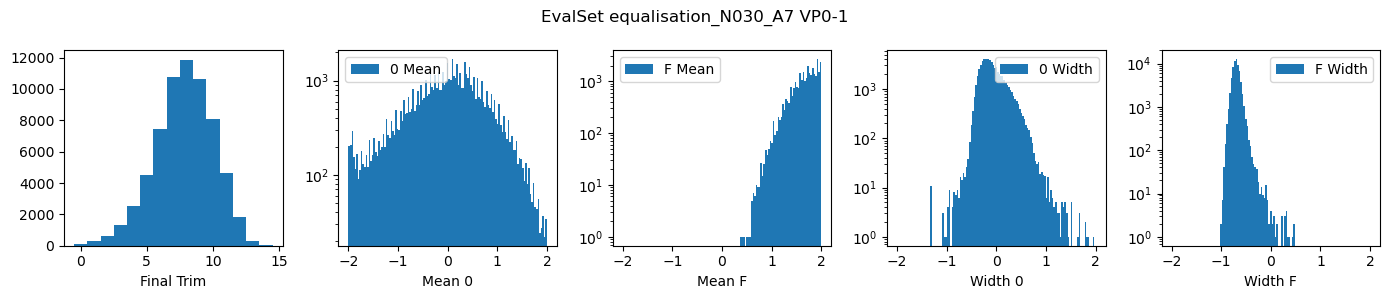

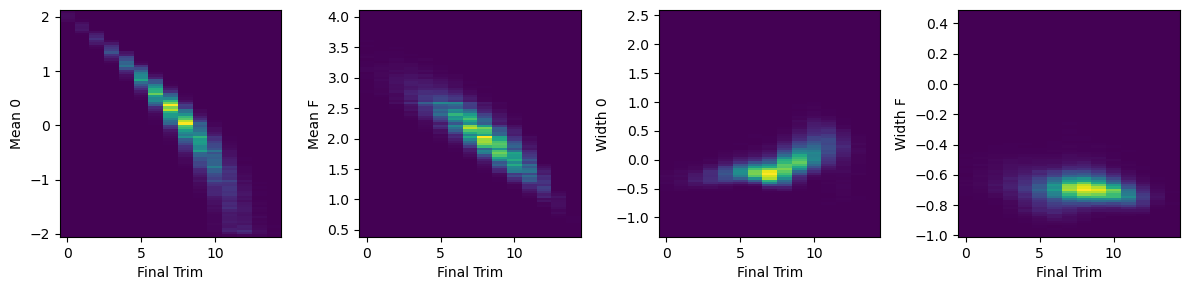

2035/2035 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - adjacent_accuracy: 0.9732 - loss: 1.0126 - sparse_categorical_accuracy: 0.5572
Testing data ('equalisation_N030_A7', 'VP0-1') score [0.9996005892753601, 0.5621083378791809, 0.9738585352897644]
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step
Using predictions directly without offset adjustments.
Confusion Matrix


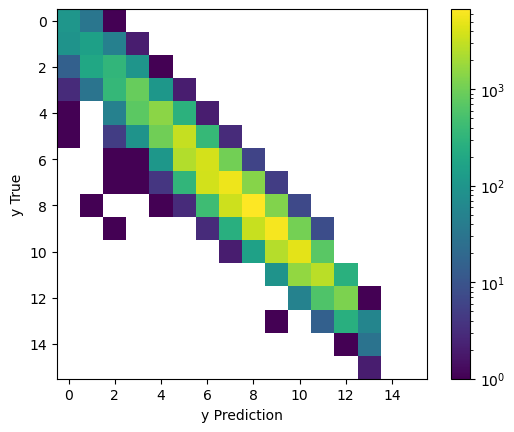

Classification Report
              precision    recall  f1-score   support

           0       0.48      0.76      0.59       136
           1       0.37      0.51      0.43       288
           2       0.43      0.52      0.47       643
           3       0.48      0.64      0.55      1346
           4       0.55      0.58      0.56      2546
           5       0.50      0.68      0.57      4543
           6       0.46      0.52      0.49      7429
           7       0.54      0.51      0.52     10772
           8       0.59      0.57      0.58     11881
           9       0.61      0.57      0.59     10647
          10       0.63      0.58      0.60      8061
          11       0.67      0.58      0.62      4637
          12       0.69      0.65      0.67      1820
          13       0.64      0.17      0.27       331
          14       0.00      0.00      0.00        30
          15       0.00      0.00      0.00         2

    accuracy                           0.56     65112
   m

c:\Users\darre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\darre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\darre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Full-Map Accuracy: 97.35% (Pixels within 1 of true value)


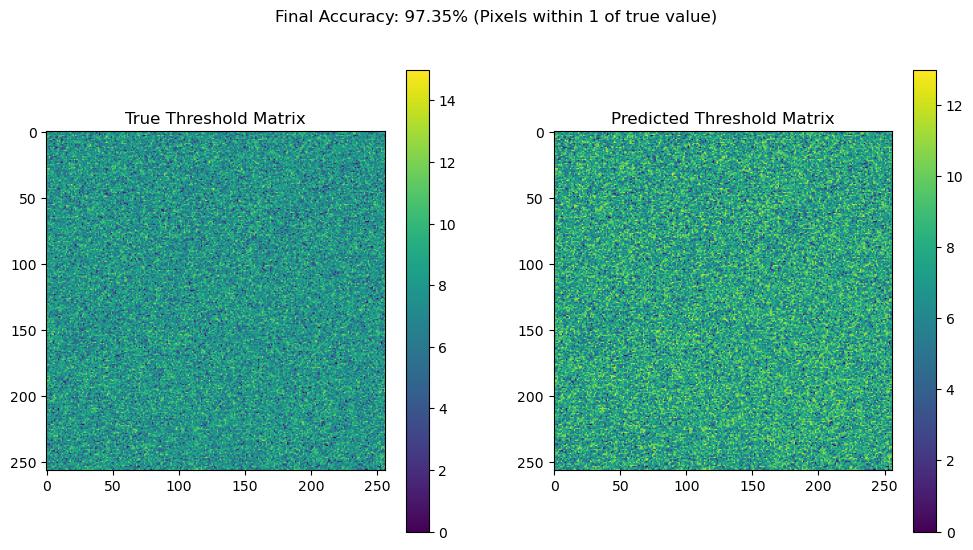

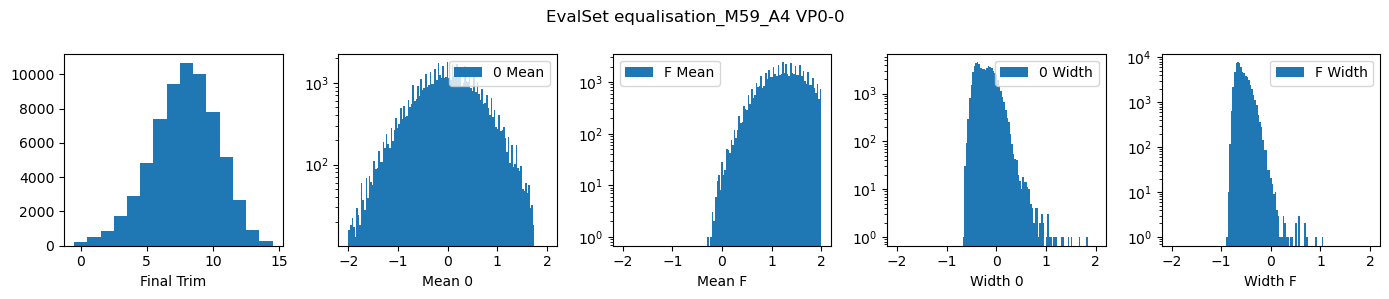

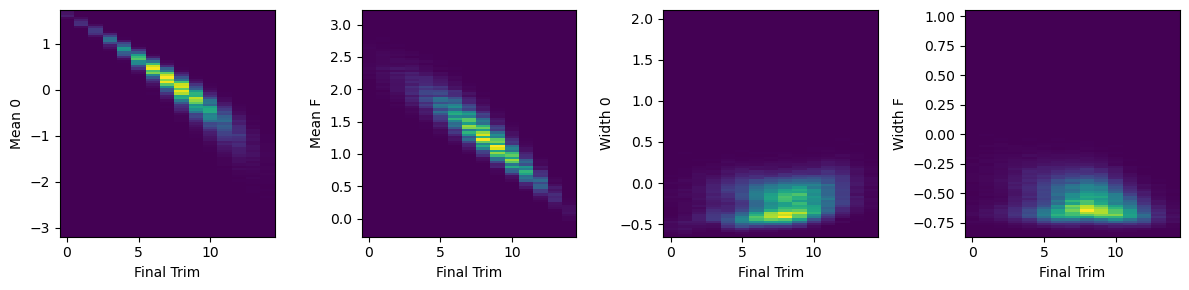

2041/2041 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - adjacent_accuracy: 0.9857 - loss: 0.9069 - sparse_categorical_accuracy: 0.5908
Testing data ('equalisation_M59_A4', 'VP0-0') score [0.9177669882774353, 0.5860015153884888, 0.9846582412719727]
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 2s 793us/step
Using predictions directly without offset adjustments.
Confusion Matrix


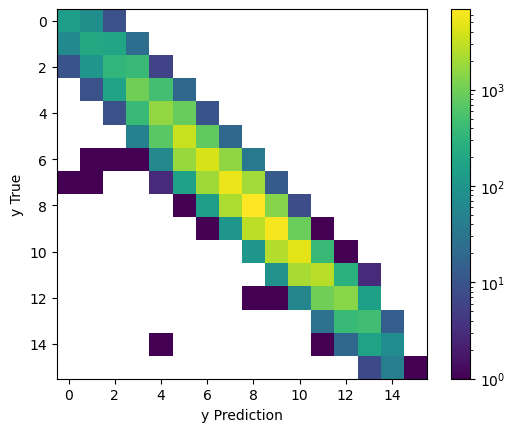

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       232
           1       0.52      0.43      0.47       486
           2       0.47      0.40      0.43       833
           3       0.55      0.60      0.57      1716
           4       0.56      0.56      0.56      2902
           5       0.54      0.67      0.60      4799
           6       0.58      0.54      0.56      7394
           7       0.57      0.56      0.56      9407
           8       0.58      0.64      0.61     10672
           9       0.61      0.61      0.61     10016
          10       0.61      0.62      0.61      7809
          11       0.65      0.51      0.57      5162
          12       0.67      0.54      0.60      2680
          13       0.58      0.50      0.54       892
          14       0.56      0.29      0.38       255
          15       1.00      0.02      0.04        52

    accuracy                           0.59     65307
   m

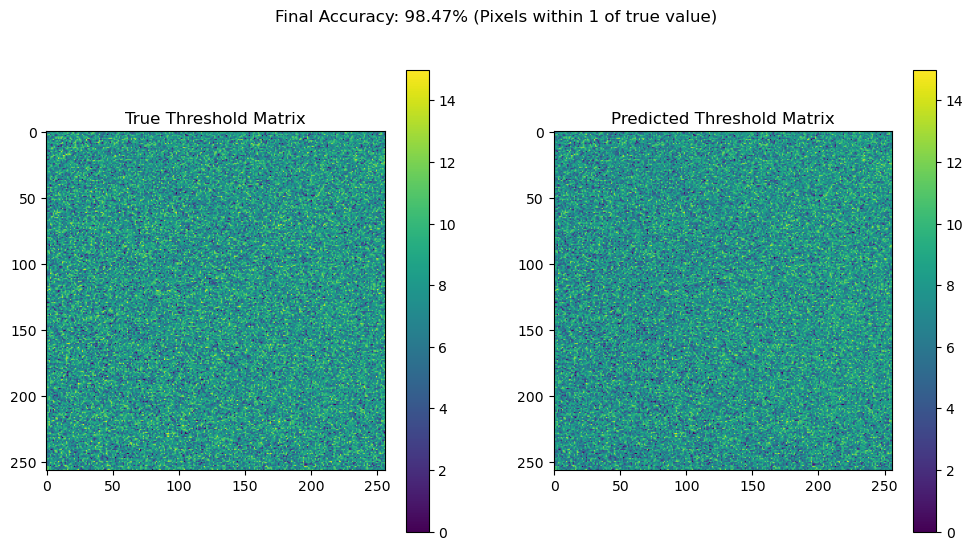

KeyboardInterrupt: 

In [9]:
import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import csv
import time

# Define training data set, slot post then ASIC
custom_objects = {"adjacent_accuracy": adjacent_accuracy}
loadFile = f"NN_{trainingSet[0][0]}_{trainingSet[0][1]}.keras"
loadModel = keras.saving.load_model(loadFile, custom_objects=custom_objects)

results = []

# Process each dataset in the evaluation set
evalSets = []  # To store processed evaluation dataset

def rebuild_full_prediction(dSet, best_y_pred, tgzFileName):
    """
    Reconstruct a 256x256 prediction array by re-inserting the predictions 
    from the filtered set. Pixels that were dropped (due to mask != 0 or any NaN)
    will be predicted as 0.
    
    Parameters:
      dSet: tuple (e.g., (modulePath, vp))
      best_y_pred: 1D NumPy array of predictions for the filtered (good) pixels
      tgzFileName: string; the path to the tar.gz file containing the CSVs
    
    Returns:
      full_prediction: a 256x256 NumPy array with predictions inserted at valid positions.
    """
    import tarfile
    import numpy as np
    
    path = dSet[0] + "/"
    
    # Load all arrays that were used for filtering
    with tarfile.open(tgzFileName, 'r:gz') as tgz:
        full_mask = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Matrix_Mask.csv", np.float16)
        tMean0   = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Trim0_Noise_Mean.csv", np.float16)
        tMeanF   = loadTGZ(tgz, path + f"Module0_{dSet[1]}_TrimF_Noise_Mean.csv", np.float16)
        tWidth0  = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Trim0_Noise_Width.csv", np.float16)
        tWidthF  = loadTGZ(tgz, path + f"Module0_{dSet[1]}_TrimF_Noise_Width.csv", np.float16)
    
    # Ensure that each array is 2D (256x256); reshape if necessary.
    arrays = [full_mask, tMean0, tMeanF, tWidth0, tWidthF]
    for i, arr in enumerate(arrays):
        if arr.ndim == 1:
            try:
                arrays[i] = arr.reshape((256, 256))
            except Exception as e:
                raise ValueError(f"Error reshaping array {i}: {e}")
    full_mask, tMean0, tMeanF, tWidth0, tWidthF = arrays
    
    # Recompute the filtering mask exactly as in removeMaskNaN:
    aMask = (full_mask == 0)
    for arr in [tMean0, tMeanF, tWidth0, tWidthF]:
        aMask &= ~np.isnan(arr)
    
    # Get the valid pixel positions as row and column indices.
    valid_rows, valid_cols = np.where(aMask)
    total_valid = len(valid_rows)
    num_predictions = best_y_pred.shape[0]
    
    # Create a full 256x256 array filled with 0's.
    full_prediction = np.zeros((256, 256), dtype=best_y_pred.dtype)
    
    if num_predictions > total_valid:
        raise ValueError("More predictions than valid pixels!")
    elif num_predictions < total_valid:
        # Some valid pixels (e.g. those with NaN in some fields) did not get a prediction.
        # We'll assume the predictions correspond to the first num_predictions valid pixels,
        # and leave the rest as 0.
        rows_to_fill = valid_rows[:num_predictions]
        cols_to_fill = valid_cols[:num_predictions]
    else:
        rows_to_fill = valid_rows
        cols_to_fill = valid_cols
    
    full_prediction[rows_to_fill, cols_to_fill] = best_y_pred
    return full_prediction

def load_full_true_matrix(dSet, tgzFileName):
    """
    Load the full 256x256 true threshold matrix from the tar.gz file.
    """
    path = dSet[0] + "/"
    with tarfile.open(tgzFileName, 'r:gz') as tgz:
        true_matrix = loadTGZ(tgz, path + f"Module0_{dSet[1]}_Matrix_Trim.csv", np.int8)
        true_matrix = true_matrix.reshape((256, 256))
    return true_matrix

def evalNN(eval, plot=True):
    evalSet = extractFromTGZ(tgzFileName, eval)  # Load an evaluation set
    evalSet = removeMaskNaN(evalSet)             # Clean set
    evalSet = normSet(evalSet)                   # Normalize the input data
    if plot:
        drawSet(evalSet, f'EvalSet {eval[0]} {eval[1]}', True)  # Optionally plot the set
    
    # Prepare input features and true labels
    x = np.column_stack([evalSet["tMean0"], evalSet["tMeanF"], 
                         evalSet["tWidth0"], evalSet["tWidthF"]])
    y_true = evalSet["trim"]
    
    # Evaluate the model on the evaluation set
    score = loadModel.evaluate(x, y_true)
    print("Testing data", eval, "score", score)
    
    # Time the prediction call
    y_pred = loadModel.predict(x)
    loss, adj_accuracy = score[0], score[2]
    
    # Get discrete predicted classes (without any offset adjustment)
    y_pred_best = np.argmax(y_pred, axis=1)
    print("Using predictions directly without offset adjustments.")
    
    # Plot confusion matrix using the direct predictions
    print('Confusion Matrix')
    im = plt.imshow(confusion_matrix(y_true, y_pred_best), norm=LogNorm())
    plt.colorbar(im)
    plt.xlabel("y Prediction")
    plt.ylabel("y True")
    plt.show()
    
    # Print classification report
    print('Classification Report')
    print(classification_report(y_true, y_pred_best))
    
    # Rebuild the full 256x256 predicted matrix using y_pred_best
    try:
        full_pred_matrix = rebuild_full_prediction(eval, y_pred_best, tgzFileName)
    except Exception as e:
        print("Error in rebuilding full prediction matrix:", e)
        return
    
    # Load the full true threshold matrix
    try:
        full_true_matrix = load_full_true_matrix(eval, tgzFileName)
    except Exception as e:
        print("Error in loading full true matrix:", e)
        return
    
    # Compute final accuracy: percentage of pixels with |predicted - true| <= 1
    final_accuracy = np.mean(np.abs(full_pred_matrix - full_true_matrix) <= 1) * 100
    print(f"Final Full-Map Accuracy: {final_accuracy:.2f}% (Pixels within 1 of true value)")
    
    # Plot the True and Predicted Matrices side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    im0 = axes[0].imshow(full_true_matrix, cmap='viridis')
    axes[0].set_title("True Threshold Matrix")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(full_pred_matrix, cmap='viridis')
    axes[1].set_title("Predicted Threshold Matrix")
    plt.colorbar(im1, ax=axes[1])
    
    plt.suptitle(f"Final Accuracy: {final_accuracy:.2f}% (Pixels within 1 of true value)")
    plt.show()
    
    results.append({
        "Dataset": f"{eval[0]}-{eval[1]}",
        "Loss": loss,
        "Accuracy": final_accuracy
    })

print("Training set demo running on the training data")
for train_data in trainingSet:  #iterate over each training dataset
    evalNN(train_data, True)

import random

random_eval_sets = random.sample(evaluationSet, 60)  #select random datasets

for s in random_eval_sets:
    print("Using",s,"as evaluation set")
    evalNN(s, True)

import os

csv_file = "final_model_results.csv"
fieldnames = ["Dataset", "Loss", "Accuracy"]
    
# Check if the file exists
if os.path.exists(csv_file):
    mode = 'a'
    write_header = False
else:
    mode = 'w'
    write_header = True

with open(csv_file, mode=mode, newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    if write_header:
        writer.writeheader()
    writer.writerows(results)

print(f"Results saved to {csv_file}")

Using ('Module25', 'VP0-0') as evaluation set


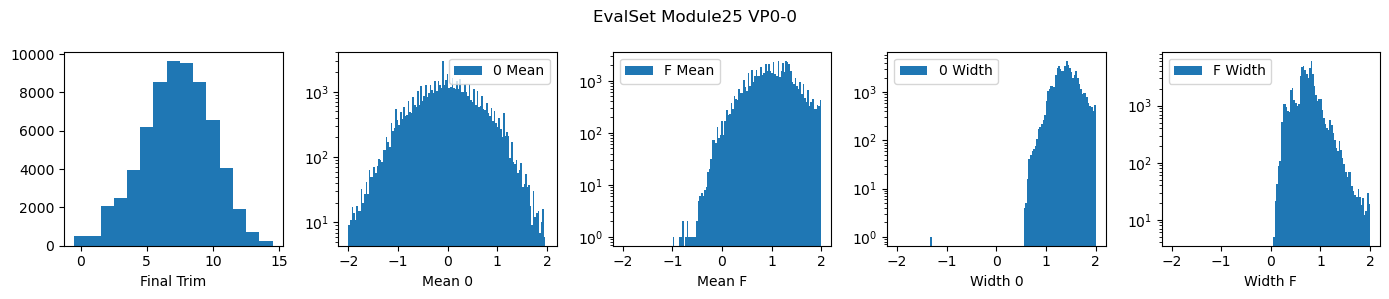

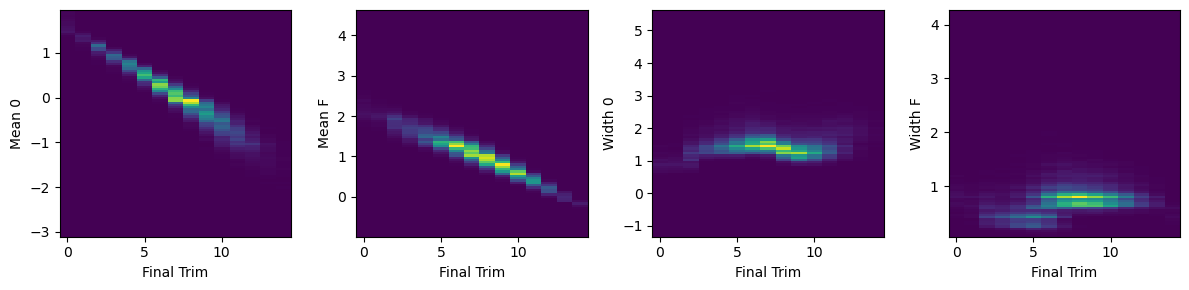

2046/2046 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - adjacent_accuracy: 0.7234 - loss: 3.0209 - sparse_categorical_accuracy: 0.2546
Testing data ('Module25', 'VP0-0') score [3.1367366313934326, 0.2454928755760193, 0.7123147249221802]
1400/2046 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step

KeyboardInterrupt: 

In [ ]:
# Define training data set, slot post then ASIC
custom_objects = {"adjacent_accuracy": adjacent_accuracy}
loadFile = f"NN_{trainingSet[0][0]}_{trainingSet[0][1]}.keras"
loadModel = keras.saving.load_model(loadFile, custom_objects=custom_objects)

def rebuild_full_prediction_new(dSet, best_y_pred, tgzFileName):
    """
    Reconstruct a 256x256 prediction array for the new operational data by re-inserting
    the predictions from the filtered set. Pixels that were dropped (due to mask != 0 or any NaN)
    will be predicted as 0.
    
    Parameters:
      dSet: tuple (e.g., ("Module25", "VP0-0"))
      best_y_pred: 1D NumPy array of predictions for the filtered (good) pixels
      tgzFileName: string; the path to the tgz file containing the CSVs
    
    Returns:
      full_prediction: a 256x256 NumPy array with predictions inserted at valid positions.
    """
    import tarfile
    import numpy as np
    
    module_prefix, vp = dSet  # unpack the new evaluation set tuple
    
    # Open the tar.gz file and load the arrays using the new naming convention:
    with tarfile.open(tgzFileName, 'r:gz') as tgz:
        full_mask = loadTGZ(tgz, f"{module_prefix}_{vp}_Matrix_Mask_2023-06-21_14-06-30.csv", np.float16, skip_header=False)
        tMean0    = loadTGZ(tgz, f"{module_prefix}_{vp}_Trim0_Noise_Mean_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        tMeanF    = loadTGZ(tgz, f"{module_prefix}_{vp}_TrimF_Noise_Mean_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        tWidth0   = loadTGZ(tgz, f"{module_prefix}_{vp}_Trim0_Noise_Width_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        tWidthF   = loadTGZ(tgz, f"{module_prefix}_{vp}_TrimF_Noise_Width_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
    
    # Ensure that each array is 2D (256x256); reshape if necessary.
    arrays = [full_mask, tMean0, tMeanF, tWidth0, tWidthF]
    for i, arr in enumerate(arrays):
        if arr.ndim == 1:
            try:
                arrays[i] = arr.reshape((256, 256))
            except Exception as e:
                raise ValueError(f"Error reshaping array {i}: {e}")
    full_mask, tMean0, tMeanF, tWidth0, tWidthF = arrays
    
    # Recompute the filtering mask (like in removeMaskNaN)
    aMask = (full_mask == 0)
    for arr in [tMean0, tMeanF, tWidth0, tWidthF]:
        aMask &= ~np.isnan(arr)
    
    # Get valid pixel positions
    valid_rows, valid_cols = np.where(aMask)
    total_valid = len(valid_rows)
    num_predictions = best_y_pred.shape[0]
    
    # Create a full 256x256 array filled with zeros (default for missing predictions)
    full_prediction = np.zeros((256, 256), dtype=best_y_pred.dtype)
    
    if num_predictions > total_valid:
        raise ValueError("More predictions than valid pixels!")
    elif num_predictions < total_valid:
        # If there are fewer predictions than valid pixels, fill only the first num_predictions positions.
        rows_to_fill = valid_rows[:num_predictions]
        cols_to_fill = valid_cols[:num_predictions]
    else:
        rows_to_fill = valid_rows
        cols_to_fill = valid_cols
    
    full_prediction[rows_to_fill, cols_to_fill] = best_y_pred
    return full_prediction

def load_full_true_matrix_new(dSet, tgzFileName):
    """
    Load the full 256x256 true threshold matrix for new operational data from the tar.gz file.
    dSet is a tuple, e.g. ("Module25", "VP0-0").
    Assumes file name format:
    Module25_VP0-0_Matrix_Trim_2023-06-21_14-06-30.csv
    """
    import tarfile
    with tarfile.open(tgzFileName, 'r:gz') as tgz:
        # Build the file name according to the new naming convention.
        file_name = f"{dSet[0]}_{dSet[1]}_Matrix_Trim_2023-06-21_14-06-30.csv"
        # For matrix files, we assume no header is present (skip_header=False).
        true_matrix = loadTGZ(tgz, file_name, np.int8, skip_header=False)
        true_matrix = true_matrix.reshape((256, 256))
    return true_matrix


def evalNN_new(eval,tgzName,plot=True):
    evalSet = extractFromTGZ_new(tgzName, eval) # Load an evaluation set
    evalSet = removeMaskNaN(evalSet)  # Clean set
    evalSet = normSet(evalSet) # use normalisation from input
    if plot : drawSet(evalSet,f'EvalSet {eval[0]} {eval[1]}',True)  # Draw it, if required
    x = np.column_stack([evalSet["tMean0"], evalSet["tMeanF"], 
                         evalSet["tWidth0"], evalSet["tWidthF"]])
    y_true = evalSet["trim"]
    score = loadModel.evaluate(x, y_true)
    print("Testing data",eval,"score",score)
    
    y_pred = loadModel.predict(x)
    loss, accuracy, adj_accuracy = score[0], score[1], score[2]
    # Confusion Matrix and Classification Report
    y_pred_best = np.argmax(y_pred, axis=1)

    # Plot confusion matrix for the best offset
    print('Confusion Matrix (Best Offset)')
    im = plt.imshow(confusion_matrix(y_true, y_pred_best), norm=LogNorm())
    plt.colorbar(im)
    plt.plot([0, 0], [15, 15], 'r-')
    plt.xlabel("y Prediction")
    plt.ylabel("y True")
    plt.show()

    # Print Classification Report
    print('Classification Report (Best Offset)')
    print(classification_report(y_true, y_pred_best))

    # --- Rebuild the full 256x256 predicted matrix ---
    try:
        full_pred_matrix = rebuild_full_prediction_new(eval, y_pred_best, tgzName)
    except Exception as e:
        print("Error in rebuilding full prediction matrix:", e)
        return

    # --- Load the full true threshold matrix ---
    try:
        full_true_matrix = load_full_true_matrix_new(eval, tgzName)
    except Exception as e:
        print("Error in loading full true matrix:", e)
        return

    # --- Compute Final Accuracy ---
    # (Percentage of pixels for which |predicted - true| <= 1)
    final_accuracy = np.mean(np.abs(full_pred_matrix - full_true_matrix) <= 1) * 100
    print(f"Final Full-Map Accuracy: {final_accuracy:.2f}% (Pixels within 1 of true value)")

    results.append({
        "Dataset": f"{eval[0]}-{eval[1]}",
        "Loss": loss,
        "Accuracy": final_accuracy
    })

    # --- Plot the True and Predicted Matrices Side by Side ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    im0 = axes[0].imshow(full_true_matrix, cmap='viridis')
    axes[0].set_title("True Threshold Matrix")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(full_pred_matrix, cmap='viridis')
    axes[1].set_title("Predicted Threshold Matrix")
    plt.colorbar(im1, ax=axes[1])
    
    plt.suptitle(f"Final Accuracy: {final_accuracy:.2f}% (Pixels within 1 of true value)")
    plt.show()

for s in evaluationSet_new:
    print("Using",s,"as evaluation set")
    evalNN_new(s,tgzFileName_new, True)
    


# Save all results to CSV
csv_file = "final_model_results_operational_data.csv"
with open(csv_file, mode='w', newline='') as file:
    fieldnames = ["Dataset", "Loss", "Accuracy"]
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)

print(f"Results saved to {csv_file}")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the Pearson correlation matrix for the DataFrame
corr_matrix = df.corr(method='pearson')

# Extract the correlations of the input features with the 'threshold'
# (Assuming 'threshold' is one of the columns in df)
corr_with_threshold = corr_matrix['threshold'].drop('threshold')

# Plot a bar plot of the correlations
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_threshold.index, y=corr_with_threshold.values)
plt.ylabel('Pearson Correlation with Threshold')
plt.xlabel('Input Features')
plt.title('Correlation of Input Features with Pixel Threshold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

In [ ]:
%timeit x = sum(range(100))

899 ns ± 30.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
